## **Identification and Segmentation of Nuclei From Images of Cell Using OpenCV, CNN and Unet**


### *Step 1: Set Up Google Drive and Import Libraries*

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/kaggle
!pwd

/content/gdrive/My Drive/kaggle
/content/gdrive/My Drive/kaggle


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from os.path import join
import glob
import sys
import random
import warnings
from tqdm import tqdm
import itertools
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Conv2D, UpSampling2D, Lambda
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
# Remember to enable GPU
%matplotlib inline

### *Step 2: Explore Data Using OpenCV*

Image segmentation can easily be performed via OpenCV, but we want to use deep learning to develop an even more accurate result.  Below is an implementation of an OpenCV image segmentation task using the same images of nuclei in cells.

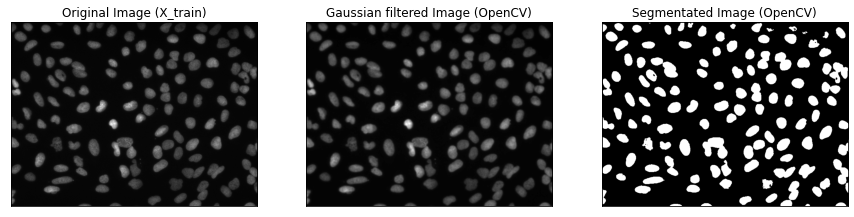

In [ ]:
def openCVdemo():
    ID = '1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180'
    FILE = "dataset/nuclei-segmentation/train/{}/images/{}.png".format(ID,ID)
    img = cv2.imread(FILE,0)
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)   
    # Plot Here
    plt.figure(figsize=(15,5))
    images = [blur, 0, th3]
    titles = ['Original Image (X_train)','Gaussian filtered Image (OpenCV)',"Segmentated Image (OpenCV)"]
    plt.subplot(1,3,1),plt.imshow(img,'gray')
    plt.title(titles[0]), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2),plt.imshow(images[0],'gray')
    plt.title(titles[1]), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,3),plt.imshow(images[2],'gray')
    plt.title(titles[2]), plt.xticks([]), plt.yticks([])
openCVdemo()

### *Step 3: Load Data (if you have a saved pickle go to Step 4b directly)*

In [ ]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'dataset/nuclei-segmentation/train/'
TEST_PATH = 'dataset/nuclei-segmentation/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
print('Done!')

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
print('\nx_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

Getting and resizing train images and masks ... 


  2%|▏         | 12/670 [02:20<2:31:10, 13.78s/it]

### *Step 4a: Save in a pickle file for faster processing*

In [ ]:
import pickle

#save the test and train so that it is easier and faster to replicate
with open('dataset/nuclei-segmentation/x_train_pickle.pkl','wb') as f:
  pickle.dump(x_train, f)

with open('dataset/nuclei-segmentation/x_test_pickle.pkl','wb') as f:
  pickle.dump(x_test, f)

with open('dataset/nuclei-segmentation/y_train_pickle.pkl','wb') as f:
  pickle.dump(y_train, f)

with open('dataset/nuclei-segmentation/y_test_pickle.pkl','wb') as f:
  pickle.dump(y_test, f)

with open('dataset/nuclei-segmentation/X.pkl','wb') as f:
  pickle.dump(X_train, f)

with open('dataset/nuclei-segmentation/Y.pkl','wb') as f:
  pickle.dump(Y_train, f)

### *Step 4b: Load from pickle file*

In [48]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'dataset/nuclei-segmentation/train/'
TEST_PATH = 'dataset/nuclei-segmentation/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

import pickle

# pickle_file = 'pkl_float32'
# pickle_file = 'pkl_uint8'
# pickle_file = 'pkl_uint8_float32'
pickle_file = 'pkl_orig'
# pickle_file = 'pkl'

#save the test and train so that it is easier and faster to replicate
with open('dataset/nuclei-segmentation/'+pickle_file+'/x_train_pickle.pkl','rb') as f:
  x_train=pickle.load(f)

with open('dataset/nuclei-segmentation/'+pickle_file+'/x_test_pickle.pkl','rb') as f:
  x_test=pickle.load(f)

with open('dataset/nuclei-segmentation/'+pickle_file+'/y_train_pickle.pkl','rb') as f:
  y_train=pickle.load(f)

with open('dataset/nuclei-segmentation/'+pickle_file+'/y_test_pickle.pkl','rb') as f:
  y_test=pickle.load(f)

In [49]:
print('\nx_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)


x_train (536, 128, 128, 3)
x_test (134, 128, 128, 3)
y_train (536, 128, 128, 1)
y_test (134, 128, 128, 1)


### *Step 5: Visualize Training Data*

In [78]:
##convert the masks from np.bool to np.float32 as tensorflow expects data to be in float32 
# format when passed into the loss function

y_test = y_test.astype(dtype='float32')
y_train = y_train.astype(dtype='float32')

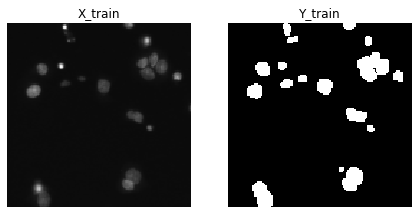

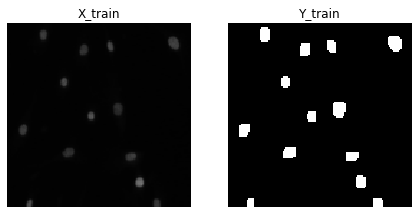

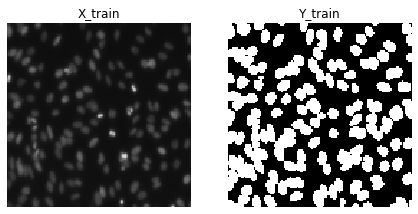

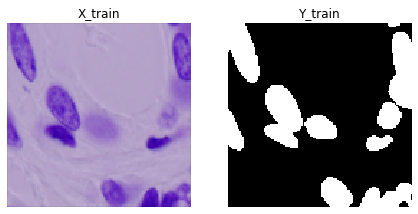

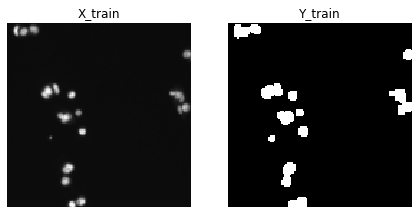

In [75]:
def plotTrainData(a,b):
    for i in range(5):
        ix = random.randint(0, len(train_ids))
        plt.subplot(1,2,1)
        plt.title("X_train")
        # imshow((a[ix] * 1).astype(np.uint8))
        imshow(a[ix])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("Y_train")
        imshow(np.squeeze(b[ix]))
        plt.axis('off')
        plt.show()
plotTrainData(x_train,y_train)

### *Step 6: Helper Functions For Visualization and Evaluation*

In [95]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy', allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('dataset/nuclei-segmentation/accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('dataset/nuclei-segmentation/loss_curve.png')

#RLE encoding for submission
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

### *Step 7: Model Using Convolutional Neural Network*

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_35 (Conv2D)           (None, None, None, 8)     224       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, None, None, 8)     584       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, None, None, 16)   

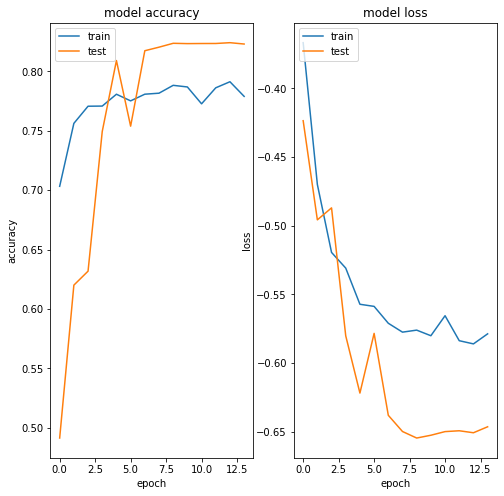

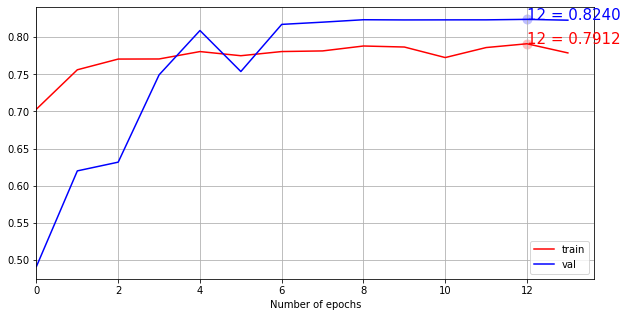

In [76]:
def SIMPLE(a,b,c,d):
    smooth = 1.
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    def dice_coef_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)
    simple_cnn = Sequential()
    simple_cnn.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS),name = 'NormalizeInput'))
    simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
    simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
    # use dilations to get a slightly larger field of view
    simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
    simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
    simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))
    # the final processing
    simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
    simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
    simple_cnn.summary()
    checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
    earlystopper = EarlyStopping(patience=5, verbose=1)
    simple_cnn.compile(optimizer = 'adam', 
                       loss = dice_coef_loss, 
                       metrics = [dice_coef, 'acc', 'mse'])
    history = simple_cnn.fit(x_train,y_train, validation_data=(x_test,y_test),callbacks = [earlystopper, checkpointer, MetricsCheckpoint('logs')],epochs = 30)
    plot_learning_curve(history)
    plt.show()
    plotKerasLearningCurve()
    plt.show()
    global modelY
    modelY = simple_cnn
    return modelY
SIMPLE(x_train, y_train,x_test,y_test)

### *Step 8: Display Result of CNN and Compare to Training Data*

5/5 [==============================] - 0s 47ms/step


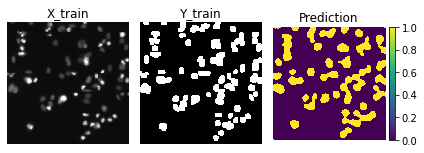

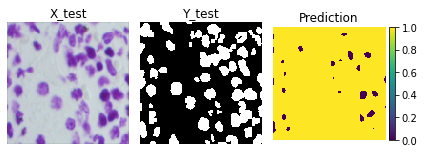

In [82]:
def plotPredictions(a,b,c,d,e):
    model = e
    # Threshold predictions
    preds_train = model.predict(a[:int(a.shape[0]*0.9)], verbose=1)
    preds_val = model.predict(a[int(a.shape[0]*0.9):], verbose=1)
    preds_test = model.predict(c, verbose=1)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    # Perform a sanity check on some random training samples
    ix = random.randint(0, len(preds_train_t))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    imshow(a[ix])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    imshow(np.squeeze(b[ix]))
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.axis('off')
    imshow(np.squeeze(preds_train_t[ix]))
    plt.show()
    # Perform a sanity check on some random validation samples
    ix = random.randint(0, len(preds_val_t))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    imshow(a[int(a.shape[0]*0.9):][ix])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    imshow(np.squeeze(b[int(b.shape[0]*0.9):][ix]))
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.axis('off')
    imshow(np.squeeze(preds_val_t[ix]))
    plt.show()
plotPredictions(x_train,y_train,x_test,y_test,modelY)

### *Step 8: Evaluate Using U-Net Architecture*

In [86]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 5.3MB/s 


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 128, 128, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 128, 128, 16) 448         lambda_8[0][0]                   
__________________________________________________________________________________________________
dropout_72 (Dropout)            (None, 128, 128, 16) 0           conv2d_194[0][0]                 
____________________________________________________________________________________________

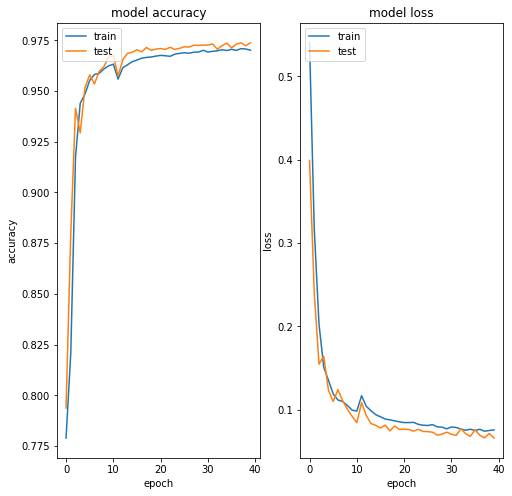

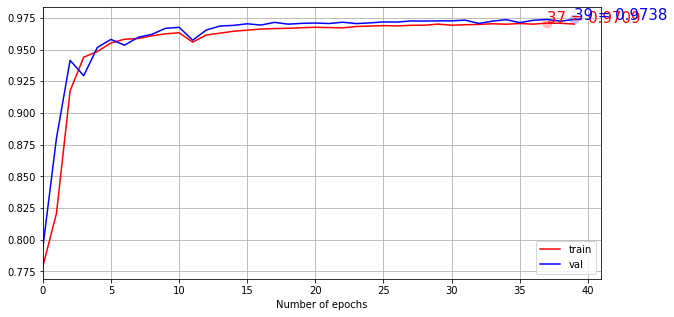

In [107]:
def UNET(a,b,c,d):
    # Build U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2),'accuracy'])
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    # Fit model
    earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint('model-dsbowl2018-2.h5', verbose=1, save_best_only=True)
    results = model.fit(a,b,batch_size=16,verbose=1,epochs=40,validation_data=(c,d),callbacks = [earlystopper, checkpointer, MetricsCheckpoint('logs')])
    plot_learning_curve(results)
    plt.show()
    plotKerasLearningCurve()
    plt.show()
    global modelZ
    modelZ = model
    return modelZ
UNET(x_train, y_train,x_test,y_test)

### *Step 9: Display Result and Compare to Training Data*

5/5 [==============================] - 0s 51ms/step


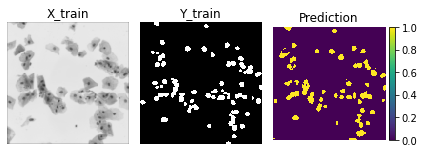

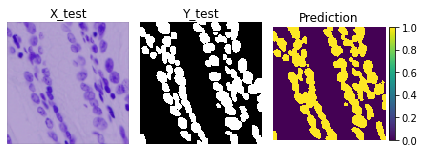

In [112]:
plotPredictions(x_train,y_train,x_test,y_test,modelZ)

## From the above results we can see that using U-Net convolutional network gives most accurate result (i.e. the predicted segmentation mask for X_train is most similar to the provided solution, Y_test).

### *Step 10: Save and Submit Results*

In [106]:
#Submit Results for OpenCV Approach
TEST_PATH = 'dataset/nuclei-segmentation/test/'
test_ids = os.listdir(TEST_PATH)
test_image_paths = [glob.glob(join(TEST_PATH, test_id, "images", "*"))[0] for test_id in test_ids]

def threshold(image_gray):
    image_gray = cv2.GaussianBlur(image_gray, (7, 7), 1)
    ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU)
    
    cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    max_cnt_area = cv2.contourArea(cnts[0])
    
    if max_cnt_area > 50000:
        ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    return thresh

def apply_morphology(thresh):
    mask = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
    return mask

segmented = []
for test_image_path in tqdm(test_image_paths):
    tmp_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    thresh = threshold(tmp_image)
    mask = apply_morphology(thresh)
    segmented.append(mask)

# Submit Results for OpenCV Approach
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(segmented[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

submission_df = pd.DataFrame()
submission_df['ImageId'] = new_test_ids
submission_df['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
#submission_df.sample(3)
#submission_df.to_csv('modelX.csv', index=False)
#print("\nMethod 1: OpenCV")
#print("Results Saved")

# Submit Results for Deep Learning Approaches
def saveResults(a,b):        
    preds_test = a.predict(b, verbose=1)
    # Create list of upsampled test masks
    preds_test_upsampled = []
    for i in range(len(preds_test)):
        preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                           (sizes_test[i][0], sizes_test[i][1]), 
                                           mode='constant', preserve_range=True))
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(test_ids):
        rle = list(prob_to_rles(preds_test_upsampled[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    # Create submission DataFrame
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    sub.to_csv(a.name+'.csv', index=False)
    print("Results Saved")
#print("\nMethod 2: Simple CNN")
#saveResults(modelY,X_test)
#print("\nMethod 3: U-Net CNN")
#saveResults(modelZ,X_test)

100%|██████████| 65/65 [00:52<00:00,  1.24it/s]


## Credit: Some functions are adaptations from https://www.kaggle.com/kmader/nuclei-overview-to-submission/notebook and https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277/notebook and https://www.kaggle.com/gaborvecsei/basic-pure-computer-vision-segmentation-lb-0-229.